In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import seaborn as sns

# 2 Multivariate OU




Suppose $X$ is a p-dimentional vector,accordingly, 
1.  $H$ is a p-dimentional matrix, assumed to be at least positive definite,
2.  $\Theta$ is a p-dimentional vector,
3.  $L$ is a Cholesky factor,lower triangnol matrix
4.  $W_{t}$ follows $N(\mathbf{0_{p \times p}},\mathbf{I_{p \times p}})$
     -  $\mathbf{0_{p \times p}}$
     -  $\mathbf{I_{p \times p}}$


$dX_t = \mathbf{H}(\Theta - X_t) dt + \mathbf{L} dW_t$ 

$X_i - X_{i-1} = \mathbf{H}(\Theta - X_i) (t_i - t_{i-1}) + \mathbf{L}\sqrt{t_i - t_{i-1}}W_t$

In [3]:
np.random.seed(123)
p=5
S =10**3*2 # steps
p_c=[10,1.5,0.5,100] # coefficient

Theta = [p_c[0]*(i+1) for i in range(0,p)]
Theta=np.reshape(Theta, (p,1))
#Theta.shape

# to generate a positive definite mx
egv_H = [p_c[1]*(i+1) for i in range(0,p)] # 
A1 = np.random.rand(p,p)*p_c[3]
Q1, _ = np.linalg.qr(A1)
D1 = np.diag(egv_H)
H = Q1 @ D1 @ Q1.T # #np.linalg.eig(H1)

# to generate a L by Cholesky decomposition
egv_L = [p_c[2]*(i+1) for i in range(0,p)]
np.random.seed(124)
A2 = np.random.rand(p,p)*p_c[3]
L = np.tril(A2)
for i in range(0,p):
    L[i,i] =egv_L[i]

In [8]:
Theta
egv_H
egv_L

[0.5, 1.0, 1.5, 2.0, 2.5]

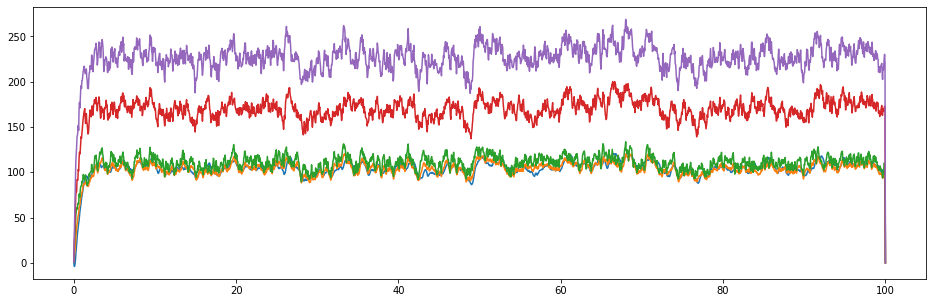

In [4]:
#----------------------------------------------------------
t = np.linspace(0, 100, S+1)
N = len(t)
dt = t[1] - t[0]
X = np.zeros((N,p))
X[0,:] = np.repeat(1.1, p)
#----------------------------------------
np.random.seed(125)
for i in range(0,S-1):
    t_x1=X[i,:].reshape((p,1)) 
    t_x2 = t_x1 + H @ (Theta- t_x1) * dt  + L * ((dt)**(1/2))  @ np.random.rand(p,1)
    X[i+1,:]=t_x2.reshape(-1)
#X#-------------------------------------------------
plt.rcParams["figure.figsize"] = (16,5) 
for i in range(0,p):
    plt.plot(t,X[:,i])

## 2.1 Numercial Solution to Optimized Parameter

md"
If $X \sim N(μ,Σ)$, then from $Y=BX+b => Y \sim N(Bμ+b,BΣB^T)$, 

thus for $X_i  = \mathbf{H}(\Theta - X_i) (t_i - t_{i-1}) + \mathbf{L}\sqrt{t_i - t_{i-1}}W_t+X_{i-1}$, 

$X_i \sim N(\mu',\Sigma')$and  

$\mu' =X_{i-1} +H(\Theta -X_i)(t_{i} -t_{i-1})$

$\Sigma' =L \sqrt{t_i-t_{i-1}}(L \sqrt{t_i-t_{i-1}})^T = \Delta t LL^L$

So the form is:

$f^{OU}(X_i|X_{i-1}; \Theta,H,L) = \frac{\mbox{Exp}\left (
-\frac{1}{2}(x_i - \mu')^T \Sigma'^{-1} (x_i - \mu') 
\right)}{\sqrt{(2 \pi)^p|\Sigma'|}}$

then

$ln f^{OU}(X_i|X_{i-1}; \Theta,H,L) =-\frac{1}{2}[(x_i - \mu')^T \Sigma'^{-1} (x_i - \mu')+ln|Σ| +pln(2 \pi)]$

"

In [24]:
p_vars.reshape((3*p,1))[0:p]

array([[10.],
       [20.],
       [30.],
       [40.],
       [50.]])

In [30]:
def Log_OU(X1,X2, dt, p_vars):
    #p_vars=np.concatenate((Theta.reshape(-1), egv_H,egv_L), axis=None)###
    #-----------------------------------------------------------
    Theta_lo=p_vars[0:p].reshape((p,1))
    # to generate a positive definite mx
    egv_H_lo=p_vars[p:2*p]
    D = np.diag(egv_H_lo)
    H_lo = Q1 @ D @ Q1.T

  # to generate a L by Cholesky decomposition
    egv_L_lo = p_vars[2*p:3*p]
    L_lo=np.tril(A2) # np.tril(A2)
    for i in range(0,p):
        L_lo[i,i] =egv_L_lo[i]
    
  #X1=X[4,:];X2=X[5,:] ##....
    X1 = X1.reshape((p,1));X2 = X2.reshape((p,1))
    mu2 = X1 + H_lo@(Theta_lo-X2)*dt
  #--------------------------------------------
    Sigma =(L_lo@L_lo.T)*dt # =(L_lo*dt**(0.5))*(L_lo*dt**(0.5)).T	
    Sigma_inv = np.linalg.inv(Sigma)
  #d = MvNormal(μ₂,Σ₂)
  #logpdf(d,X2)
    t1 = X2-mu2
    t2 = np.log(np.linalg.det(Sigma))
    t3 = p*(np.log(2*np.pi))
  #----------------------------
    res = t1.T @ Sigma_inv @ t1 + t2 + t3
    return -0.5*res

#p_vars=np.concatenate((Theta.reshape(-1), egv_H,egv_L), axis=None)

X1=X[4,:];X2=X[5,:]
p_vars=np.concatenate((Theta.reshape(-1), egv_H,egv_L), axis=None)
Log_OU(X1,X2, dt, p_vars)

array([[-8.52049421e+11]])

In [31]:
def nllf_OU(X,dt,p_vars):
    lf = np.zeros((N-1,) )
    for i in range(1,N):
        X2 = X[i]
        X1 = X[i-1]
        lf[i-1] = Log_OU(X1,X2, dt, p_vars)

    return -sum(lf)


nllf_OU(X,dt,p_vars)

4693806647539902.0

In [32]:
#  H and sigma must be greater than zero.  We use these contraint functions with minimze
def constraint_H(p_vars ):
    return p_vars[p:2*p]

def constraint_L(p_vars ):
    return p_vars[2*p:3*p]

constraint_H(p_vars )
constraint_L(p_vars )

array([0.5, 1. , 1.5, 2. , 2.5])

In [35]:
[1 for i in range(1,3*p+1)]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [43]:
cons = ( {'type':'ineq', 'fun': constraint_H},
         {'type':'ineq', 'fun': constraint_L} )

#  Initial guess for our parameters
p0 = [1 for i in range(1,3*p+1)]#np.repeat(1,3*p)
p0 =np.array(p0)

minimize(fun=nllf_OU, x0=p0, args = (X, dt),method='Nelder-Mead' #constraints=cons
         )

IndexError: invalid index to scalar variable.

In [32]:
X[10]

array([ 5.14770482, 16.10713706])